# TensorFlow によるモデルの学習とホスティング

TensorFlow を SageMaker 上で学習し、ホスティングするノートブックです。既存のコードに少しの変更を加えるだけで、SageMaker 上で TensorFlow のモデルを学習し、ホスティングすることが可能です。

[SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) は、SageMaker学習インスタンスへのスクリプトの転送を処理します。学習インスタンスでは、SageMakerのネイティブTensorFlowサポートが学習関連の環境変数を設定し、学習スクリプトを実行します。このチュートリアルでは、SageMaker Python SDKを使用して学習ジョブを起動し、学習されたモデルを展開します。
TensorFlow Training についての詳細についてはこちらの[ドキュメント](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/using_tf.html#train-a-model-with-tensorflow)にアクセスしてください

この例では、Pythonスクリプトを使用して、MNISTデータセット（手書き数字画像のデータセット）の分類モデルを学習します。さらに、このノートブックは、[SageMaker TensorFlow Serving container](https://github.com/aws/sagemaker-tensorflow-serving-container)でリアルタイム推論を実行する方法を示します。 TensorFlow hosting の詳細なドキュメントについては、[こちら](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/deploying_tensorflow_serving.html) にアクセスしてください。

※本ノートブックは TensorFlow バージョン 2 以上で動作します。

---

## コンテンツ

1. [環境のセットアップ](#1.環境のセットアップ)
1. [学習データの準備](#2.学習データの準備)
1. [分散学習用のスクリプトを作成する](#3.分散学習用のスクリプトを作成する)
1. [TensorFlow Estimator を利用して学習ジョブを作成する](#4.TensorFlowEstimatorを利用して学習ジョブを作成する)
1. [学習したモデルをエンドポイントにデプロイする](#5.学習したモデルをエンドポイントにデプロイする)
1. [エンドポイントを呼び出し推論を実行する](#6.エンドポイントを呼び出し推論を実行する)
1. [エンドポイントを削除する](#7.エンドポイントを削除する)
---


# 1.環境のセットアップ

まずは環境のセットアップを行いましょう。

In [14]:
import os, sagemaker, urllib
import matplotlib.pyplot as plt
import numpy as np

from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()
region = sagemaker_session.boto_session.region_name

print(f'Current SageMaker Python SDK Version = {sagemaker.__version__}')

Current SageMaker Python SDK Version = 2.25.2


注） このノートブックでは SageMaker SDK が 2.19.0 以上で動作します。上記の出力結果がそれ以前のバージョンになった際は、下記のセルの#を削除（コメントアウトを解除）して実行、Jupyterカーネルを再起動し、再度上記のセルを実行し、バージョンがアップデートされたことを確認してください。カーネルが再起動されない場合は、SageMaker SDK バージョン更新が反映されません。

In [15]:
# !pip install -U --quiet "sagemaker>=2.19.0"

# 2.学習データの準備

MNISTデータセットは、パブリックS3バケット ``sagemaker-sample-data-<REGION>`` の下のプレフィックス ``tensorflow/mnist`` の下にロードされています。 このプレフィックスの下には4つの ``.npy`` ファイルがあります：
* ``train_data.npy``
* ``eval_data.npy``
* ``train_labels.npy``
* ``eval_labels.npy``

学習データが保存されている s3 の URI を変数に格納しておきます。

In [16]:
training_data_uri = f's3://sagemaker-sample-data-{region}/tensorflow/mnist/'
print(training_data_uri)
!aws s3 ls {training_data_uri}

s3://sagemaker-sample-data-us-east-1/tensorflow/mnist/
2019-01-24 23:36:40   31360128 eval_data.npy
2019-01-24 23:36:40      40128 eval_labels.npy
2019-01-24 23:36:40  172480128 train_data.npy
2019-01-24 23:36:40     220128 train_labels.npy


# 3.分散学習用のスクリプトを作成する

このチュートリアルの学習スクリプトは、TensorFlowの公式の [CNN MNISTの例](https://www.tensorflow.org/tutorials/images/cnn?hl=ja) をベースに作成されました。 SageMaker から渡された `` model_dir`` パラメーターを処理するように変更しています。 これは、分散学習時のデータ共有、チェックポイント、モデルの永続保存などに使用できるS3パスです。 また、学習関連の変数を扱うために、引数をパースする関数も追加しました。

学習ジョブの最後に、学習済みモデルを環境変数 ``SM_MODEL_DIR`` に保存されているパスにエクスポートするステップを追加しました。このパスは常に ``/opt/ml/model`` をポイントします。 SageMaker は、学習の終了時にこのフォルダー内のすべてのモデル成果物をS3にアップロードするため、これは重要です。

スクリプト全体は次のとおりです。

In [17]:
!pygmentize 'mnist.py'

# Copyright 2018-2019 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.
"""Convolutional Neural Network Estimator for MNIST, built with tensorflow.keras.layers."""

import numpy as np
import tensorflow as tf
import os,json,argparse
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy


def model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='rel

\# 4.TensorFlowEstimatorを利用して学習ジョブを作成する

`sagemaker.tensorflow.TensorFlow`　estimator は、スクリプトモード対応の TensorFlow コンテナの指定、学習・推論スクリプトの S3 へのアップロード、および SageMaker 学習ジョブの作成を行います。ここでいくつかの重要なパラメーターを呼び出しましょう。

* `py_version`は` 'py3'`に設定されています。レガシーモードは Python 2 のみをサポートしているため、この学習スクリプトはスクリプトモードを使用していることを示しています。Python2は間もなく廃止されますが、 `py_version` を設定することでPython 2でスクリプトモードを使用できます。`'py2'`と` script_mode`を `True`にします。

* `distributions` は、分散学習設定を構成するために使用されます。インスタンスのクラスターまたは複数の GPU をまたいで分散学習を行う場合にのみ必要です。ここでは、分散学習スキーマとしてパラメーターサーバーを使用しています。 SageMaker 学習ジョブは同種のクラスターで実行されます。 SageMaker セットアップでパラメーターサーバーのパフォーマンスを向上させるために、クラスター内のすべてのインスタンスでパラメーターサーバーを実行するため、起動するパラメーターサーバーの数を指定する必要はありません。スクリプトモードは、[Horovod](https://github.com/horovod/horovod) による分散学習もサポートしています。 `distributions` の設定方法に関する詳細なドキュメントは[こちら](https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/tensorflow#distributed-training) をご参照ください。

* 実際にモデル開発をする際はコード(ここでは `mnist.py` )にバグが混入していないか確認しながら実行することになりますが、学習インスタンスを利用すると、インスタンスの起動に時間がかかるため、学習開始コマンドを打ち込んでから 10 分後に気づいてやり直し、となってしまうことがあります。そのオーバヘッドを防止するために、ローカルモードでの学習が Sagemaker ではサポートされています。``instance_type=local``を指定するだけで、ノートブックインスタンスで学習（＝インスタンスの立ち上げ時間なしで）を試すことができます。よくやるやり方としてはコードの確認用途のため、 epoch の数やデータを減らして動くかどうかの確認を行うことが多いです。

また、Spot Instanceを用いて実行する場合は、下記のコードを `Estimator` の `train_instance_type` の次の行に追加しましょう。

```python
                             max_run = 5000, # 学習は最大で5000秒までにする設定
                             use_spot_instances = 'True',
                             max_wait = 7200 # 学習完了を待つ最大時間
```




In [18]:
from sagemaker.tensorflow import TensorFlow


mnist_estimator = TensorFlow(entry_point='mnist.py',
                             role=role,
                             instance_count=2,
                             # instance_type='local',
                             instance_type='ml.p3.2xlarge',
                             framework_version='2.1.0',
                             py_version='py3',
                             distribution={'parameter_server': {'enabled': True}},
                             hyperparameters={
                                 "epochs": 4,
                                 'batch-size':16
                             }
#                              max_run = 5000, # 学習は最大で5000秒までにする設定
#                              use_spot_instances = 'True',
#                              max_wait = 7200 # 学習完了を待つ最大時間
                            )

## ``fit`` による学習ジョブの実行

学習ジョブを開始するには、`estimator.fit（training_data_uri）` を呼び出します。

ここでは、S3 ロケーションが入力として使用されます。 `fit` は、`training` という名前のデフォルトチャネルを作成します。これは、このS3ロケーションを指します。学習スクリプトでは、 `SM_CHANNEL_TRAINING` に保存されている場所から学習データにアクセスできます。 `fit`は、他のいくつかのタイプの入力も受け入れます。詳細については、APIドキュメント[こちら](https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.EstimatorBase.fit) を参照してください。

学習が開始されると、TensorFlow コンテナは mnist.py を実行し、スクリプトの引数として　estimator から`hyperparameters` と `model_dir` を渡します。この例では、estimator 内で定義していないハイパーパラメーターは渡されず、 `model_dir` のデフォルトは `s3://<DEFAULT_BUCKET>/<TRAINING_JOB_NAME>` であるため、スクリプトの実行は次のようになります。
```bash
python mnist.py --model_dir s3://<DEFAULT_BUCKET>/<TRAINING_JOB_NAME>
```
学習が完了すると、学習ジョブは保存されたモデルを TensorFlow serving にアップロードします。

In [19]:
mnist_estimator.fit(training_data_uri)

2021-03-13 07:00:15 Starting - Starting the training job...
2021-03-13 07:00:40 Starting - Launching requested ML instancesProfilerReport-1615618814: InProgress
......
2021-03-13 07:01:40 Starting - Preparing the instances for training......
2021-03-13 07:02:41 Downloading - Downloading input data...
2021-03-13 07:03:01 Training - Downloading the training image........2021-03-13 07:04:23,836 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-03-13 07:04:24,090 sagemaker_tensorflow_container.training INFO     Running distributed training job with parameter servers
2021-03-13 07:04:24,091 sagemaker_tensorflow_container.training INFO     Launching parameter server process
2021-03-13 07:04:24,091 sagemaker_tensorflow_container.training INFO     Running distributed training job with parameter servers
2021-03-13 07:04:24,919 sagemaker_tensorflow_container.training INFO     Launching worker process
2021-03-13 07:04:25,139 sagemaker-containers INFO   


2021-03-13 07:04:42 Training - Training image download completed. Training in progress.#015   16/55000 [..............................] - ETA: 3:15:46 - loss: 2.3033 - accuracy: 0.1250#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  272/55000 [..............................] - ETA: 11:38 - loss: 2.2916 - accuracy: 0.1618  #010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

s - loss: 0.5641 - accuracy: 0.8460#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#01524768/55000 [============>.................] - ETA: 10s - loss: 0.5606 - accuracy: 0.8469#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#01525024/55000 [============>.................] - ETA: 9s - loss: 0.5568 - accuracy: 0.8479 #010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#01

#015   16/55000 [..............................] - ETA: 14s - loss: 0.0950 - accuracy: 0.9375#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  288/55000 [..............................] - ETA: 10s - loss: 0.1790 - accuracy: 0.9479#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  560/55000 [..............................] - ETA: 10s - loss: 0.1366 - accuracy: 0.9589#010#010#

#015   16/55000 [..............................] - ETA: 13s - loss: 0.0143 - accuracy: 1.0000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  288/55000 [..............................] - ETA: 10s - loss: 0.0458 - accuracy: 0.9896#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  560/55000 [..............................] - ETA: 10s - loss: 0.0547 - accuracy: 0.9804#010#010#

#015   16/55000 [..............................] - ETA: 13s - loss: 0.0116 - accuracy: 1.0000#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  288/55000 [..............................] - ETA: 10s - loss: 0.0271 - accuracy: 0.9931#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015  560/55000 [..............................] - ETA: 10s - loss: 0.0252 - accuracy: 0.9946#010#010#


2021-03-13 07:05:43 Uploading - Uploading generated training model
2021-03-13 07:05:43 Completed - Training job completed
ProfilerReport-1615618814: NoIssuesFound
Training seconds: 342
Billable seconds: 342


# 5.学習したモデルを推論用エンドポイントにデプロイする

`deploy（）`メソッドは SageMaker モデルを作成します。このモデルはエンドポイントにデプロイされ、リアルタイムで予測リクエストを処理します。 スクリプトモードで学習したため、エンドポイントには TensorFlow Serving コンテナを使用します。 このサービングコンテナは、SageMaker ホスティングプロトコルと互換性のあるWebサーバーの実装を実行します。 [独自の推論コードの使用](https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/your-algorithms-inference-main.html) ドキュメントでは、SageMaker が推論コンテナを実行する方法について説明しています。

学習時と同様、 `instance_type` を `local` に指定するとノートブックインスタンスにデプロイすることが可能です。

In [20]:
# predictor = mnist_estimator.deploy(initial_instance_count=1, instance_type='local')
predictor = mnist_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------------!

# 6.エンドポイントを呼び出し推論を実行する

学習データをダウンロードして、推論の入力として使用してみましょう。

入力データと出力データの形式は、[TensorFlow Serving REST API](https://www.tensorflow.org/serving/api_rest) の `Predict`メソッドのリクエストとレスポンスの形式に直接対応しています。 SageMaker の TensforFlow Serving エンドポイントは、単純化されたJSON形式、行区切りのJSONオブジェクト ("jsons" または "jsonlines")、CSV データなど、TensorFlow REST API の一部ではない追加の入力形式も受け入れることができます。

この例では、入力として `numpy` 配列を使用しています。これは、簡略化されたJSON形式にシリアル化されます。 さらに、TensorFlow serving は、次のコードに示すように、複数のアイテムを一度に処理することもできます。 TensorFlow serving を用いた SageMaker エンドポイントに対して予測を行う方法に関する詳細なドキュメントは[こちら](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/deploying_tensorflow_serving.rst#making-predictions-against-a-sagemaker-endpoint)をご参照ください。

まず、評価用のデータセットを取得します。

In [21]:
!aws --region {region} s3 cp s3://sagemaker-sample-data-{region}/tensorflow/mnist/eval_data.npy eval_data.npy
!aws --region {region} s3 cp s3://sagemaker-sample-data-{region}/tensorflow/mnist/eval_labels.npy eval_labels.npy

eval_data = np.load('eval_data.npy').reshape(-1,28,28,1)
eval_labels = np.load('eval_labels.npy')

download: s3://sagemaker-sample-data-us-east-1/tensorflow/mnist/eval_data.npy to ./eval_data.npy
download: s3://sagemaker-sample-data-us-east-1/tensorflow/mnist/eval_labels.npy to ./eval_labels.npy


下記の ``k　= `` に、9950 までの好きな数字を入れて、評価する手書き文字のセットを選択しましょう。
`predictor.predict(test_data)` で推論を行い、選んだ手書き文字認識に対する `prediction is`: 推論結果 と、`label is`: 実際のラベルの値が出力され、その二つが一致していれば最後に `matched: True` と表示されます。

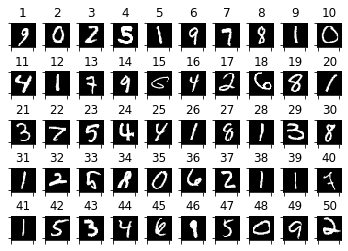

In [22]:
k = 1000 # choose your favorite number from 0 to 9950
test_data = eval_data[k:k+50]
test_data

for i in range(5):
    for j in range(10):
        plt.subplot(5, 10, 10* i + j+1)
        plt.imshow(test_data[10 * i + j, :].reshape(28, 28), cmap='gray')
        plt.title(10* i + j+1)
        plt.tick_params(labelbottom=False, labelleft = False)
        plt.subplots_adjust(wspace=0.2, hspace=1)
plt.show()

In [23]:
predictions = predictor.predict(test_data.reshape(-1,28,28,1))
count_true = 0
for i in range(0, 50):
    prediction = np.argmax(predictions['predictions'][i])
    label = eval_labels[i+k]
    if prediction == label:
        count_true += 1
    print(' [{}]: prediction is {}, label is {}, matched: {}'.format(i+1, prediction, label, prediction == label))
    
print('Accuracy: ', (count_true/50.0))

 [1]: prediction is 9, label is 9, matched: True
 [2]: prediction is 0, label is 0, matched: True
 [3]: prediction is 2, label is 2, matched: True
 [4]: prediction is 5, label is 5, matched: True
 [5]: prediction is 1, label is 1, matched: True
 [6]: prediction is 9, label is 9, matched: True
 [7]: prediction is 7, label is 7, matched: True
 [8]: prediction is 8, label is 8, matched: True
 [9]: prediction is 1, label is 1, matched: True
 [10]: prediction is 0, label is 0, matched: True
 [11]: prediction is 4, label is 4, matched: True
 [12]: prediction is 1, label is 1, matched: True
 [13]: prediction is 7, label is 7, matched: True
 [14]: prediction is 9, label is 9, matched: True
 [15]: prediction is 5, label is 6, matched: False
 [16]: prediction is 4, label is 4, matched: True
 [17]: prediction is 2, label is 2, matched: True
 [18]: prediction is 6, label is 6, matched: True
 [19]: prediction is 8, label is 8, matched: True
 [20]: prediction is 1, label is 1, matched: True
 [21]: p

# 7.エンドポイントを削除する

推論用エンドポイントは停止されるまで課金が発生します。そのため。不要になったエンドポイントはすぐに削除することをおすすめします。以下のコードでエンドポイントが削除されます。AWS コンソールの左側のメニューから「エンドポイント」をクリックし、停止したいエンドポイントを選択して削除することも可能です。

In [11]:
predictor.delete_endpoint()